<a href="https://colab.research.google.com/github/ericbonelli/Cientista-de-Dados_EBAC/blob/main/mod27_Tarefa02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

filename_features = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/features.txt"
filename_labels = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Desenvolvimento Modelos com Pandas e Python/Árvore de classificação 2/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt"

# Carregar os nomes das features e resolver duplicatas
raw_features = pd.read_csv(filename_features, sep="\s+", header=None)[1]
feature_counts = Counter(raw_features)
seen = {}
features = []

for name in raw_features:
    if feature_counts[name] > 1:
        count = seen.get(name, 0) + 1
        seen[name] = count
        features.append(f"{name}_{count}")
    else:
        features.append(name)

# Carregar demais dados
labels = pd.read_csv(filename_labels, sep='\s+', header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None)[0]
X_train = pd.read_csv(filename_xtrain, sep='\s+', header=None, names=features)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None)[0]
X_test = pd.read_csv(ffilename_xtest, sep='\s+', header=None, names=features)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

## Com Padronização

In [42]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: user 210 ms, sys: 6.95 ms, total: 217 ms
Wall time: 217 ms


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [5]:
prcomp = PCA().fit(X_train_pad)

In [6]:
def screeplot(princomp, ncomp = 0, varexplicada=0, criterio=1):

    if ncomp>0:
        ncomp_crit=ncomp
    elif varexplicada > 0:
        ncomp_crit = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1
        # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()
    else: ncomp_crit = None

    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=.15)


    num_componentes = np.arange(princomp.n_components_) + 1
    ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


    ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

    if ncomp_crit != None:
        # Linhas verticais de referência
        ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)


        # linhas horizontais
        variancia               = princomp.explained_variance_[ncomp_crit-1]
        variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_crit-1]
        pct_variancia           = princomp.explained_variance_ratio_[ncomp_crit-1]
        pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_crit-1]

        ax[0,0].axhline(y = variancia              , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axhline(y = variancia_acumulada    , color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axhline(y = pct_variancia          , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axhline(y = pct_variancia_acumulada, color = 'r', linestyle = '-', linewidth=.5)


    print(f'Número de componentes:............... {ncomp_crit}')
    print(f'Variância da ultima CP:.............. {variancia:.2f}' )
    print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
    print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
    print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )
    plt.show()
    return ncomp_crit

Número de componentes:............... 63
Variância da ultima CP:.............. 0.99
Variância total explicada:........... 505.20
Variância percentual da última CP:... 0.18%
Variância percentual total explicada: 90.05%


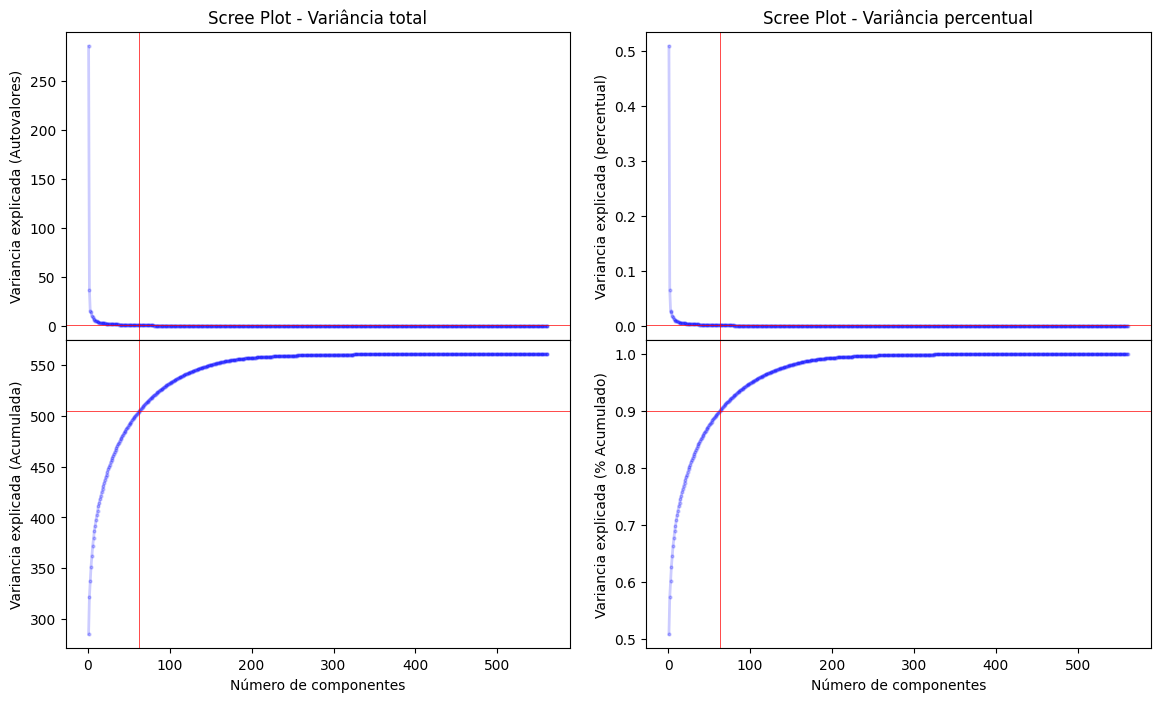

In [7]:
ncomp = screeplot(prcomp, varexplicada=.90)

## Sem Padronização

In [8]:
prcomp = PCA().fit(X_train)

In [ ]:
def screeplot(princomp, ncomp = 0, varexplicada=0, criterio=1):

    if ncomp>0:
        ncomp_crit=ncomp
    elif varexplicada > 0:
        ncomp_crit = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1
        # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()
    else: ncomp_crit = None

    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=.15)


    num_componentes = np.arange(princomp.n_components_) + 1
    ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


    ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

    if ncomp_crit != None:
        # Linhas verticais de referência
        ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)


        # linhas horizontais
        variancia               = princomp.explained_variance_[ncomp_crit-1]
        variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_crit-1]
        pct_variancia           = princomp.explained_variance_ratio_[ncomp_crit-1]
        pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_crit-1]

        ax[0,0].axhline(y = variancia              , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axhline(y = variancia_acumulada    , color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axhline(y = pct_variancia          , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axhline(y = pct_variancia_acumulada, color = 'r', linestyle = '-', linewidth=.5)


    print(f'Número de componentes:............... {ncomp_crit}')
    print(f'Variância da ultima CP:.............. {variancia:.2f}' )
    print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
    print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
    print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )
    plt.show()
    return ncomp_crit

Número de componentes:............... 34
Variância da ultima CP:.............. 0.13
Variância total explicada:........... 50.15
Variância percentual da última CP:... 0.24%
Variância percentual total explicada: 90.09%


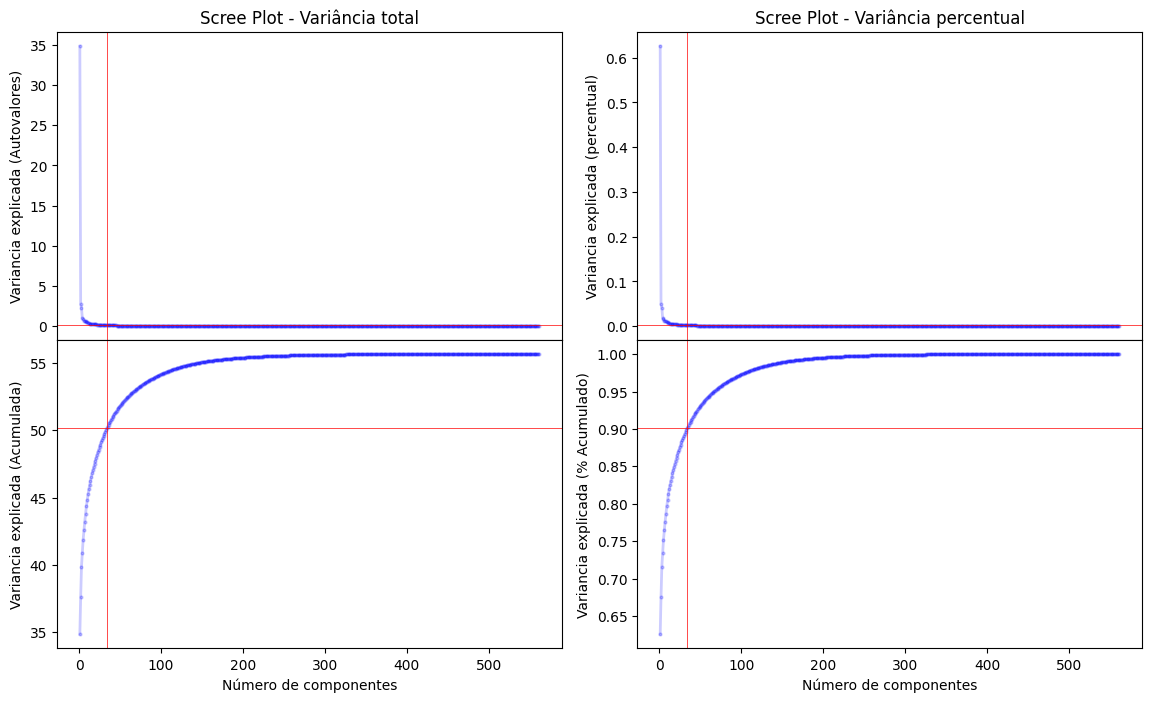

In [9]:
ncomp = screeplot(prcomp, varexplicada=.90)

### 📊 Comparativo: PCA com vs. sem Padronização

| Métrica                                 | **Com Padronização**        | **Sem Padronização**       |
|----------------------------------------|------------------------------:|-----------------------------:|
| Número de Componentes                   | 63                           | 34                          |
| Variância da Última CP                 | 0.99                         | 0.13                        |
| Variância Total Explicada              | 505.20                       | 50.15                       |
| Variância Percentual da Última CP      | 0.18%                        | 0.24%                       |
| Variância Percentual Total Explicada   | 90.05%                       | 90.09%                      |

---

### 📌 Observações Importantes

- **Com padronização**:
  - O PCA considera todas as variáveis na mesma escala.
  - Requer mais componentes para atingir 90% da variância, pois a variância é redistribuída de forma mais uniforme entre os componentes.
  - A variância total (soma dos autovalores) é maior porque as variáveis foram escaladas (média 0, desvio padrão 1).

- **Sem padronização**:
  - As variáveis com maior variância (maior escala) dominam a explicação.
  - Menor número de componentes necessários.
  - Pode ser tendencioso se as variáveis tiverem escalas muito diferentes.

---

### ✅ Conclusão

A escolha entre padronizar ou não depende da escala das variáveis:
- Se as variáveis têm escalas **muito diferentes**, **padronizar é essencial**.
- Se todas as variáveis já estão na **mesma unidade/escala**, pode-se aplicar PCA diretamente.


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

## Com Padronização

In [45]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)
X_test_pad.head()

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 181 ms


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,-0.277661,-0.210595,2.192704,-0.787134,-0.833071,-0.093428,-0.807954,-0.838871,-0.104160,-0.824606,...,-0.253620,-0.166362,-0.344707,0.003565,0.357512,-1.363669,0.575389,-0.404722,0.622618,-0.038342
1,0.198626,0.182560,-0.250221,-0.876836,-0.928903,-0.857905,-0.896993,-0.928791,-0.863122,-0.824606,...,-2.300359,0.490938,0.012254,-0.264048,0.030782,-0.747105,1.870875,-0.361677,0.636623,-0.145684
2,0.024583,-0.318001,-0.228446,-0.921442,-0.933896,-0.906953,-0.916735,-0.933654,-0.912484,-0.910827,...,-0.291514,0.274775,-0.134966,-0.119651,0.445996,0.037913,0.323883,-0.370869,0.632738,-0.126834
3,-0.061047,-0.572940,-0.213673,-0.923681,-0.940657,-0.918926,-0.918996,-0.941439,-0.927619,-0.909586,...,-0.058615,-0.210642,-0.441639,-0.066432,0.338455,0.472614,0.625768,-0.363372,0.645167,-0.117565
4,0.013820,-0.387815,-0.494555,-0.921523,-0.928878,-0.949818,-0.915977,-0.923689,-0.951235,-0.909586,...,-1.090596,-0.810389,-0.796804,-0.022272,-0.098513,1.097162,-0.201965,-0.350197,0.665544,-0.104100


In [44]:
X_train_pad, X_valid_pad, y_train_split, y_valid_split = train_test_split(X_train_pad, y_train, test_size=0.25, random_state=42)

In [46]:
%%time
pca = PCA(n_components=10)
pc_treino = pca.fit_transform(X_train_pad)
pc_valida = pca.transform(X_valid_pad)
pc_teste = pca.transform(X_test_pad)


n = 10  # Certifique-se de definir aqui também
colunas = ['cp'+str(x+1) for x in range(n)]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_valid = pd.DataFrame(pc_valida[:, :n], columns=colunas)
pc_test  = pd.DataFrame(pc_teste[:, :n],  columns=colunas)

CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 792 ms


In [47]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train_split)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train_split)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train_split)
    clfs.append(clf)

CPU times: user 11.6 s, sys: 155 µs, total: 11.6 s
Wall time: 12.8 s


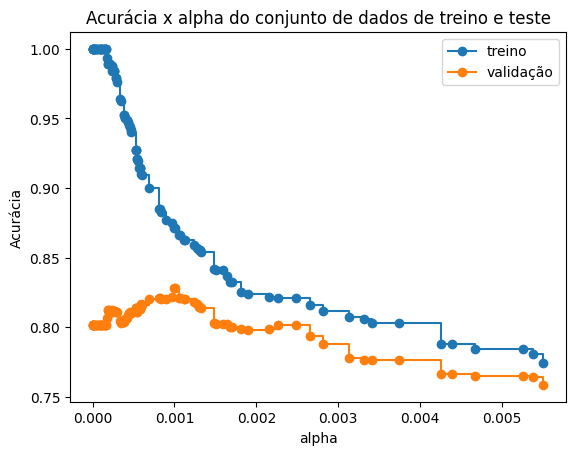

In [48]:
train_scores = [clf.score(pc_train, y_train_split) for clf in clfs]
valid_scores = [clf.score(pc_valid, y_valid_split) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], valid_scores[:nx], marker='o', label="validação", drawstyle="steps-post")

ax.legend()
plt.show()

In [49]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    87.1
Acurácia da melhor árvore na base de validação: 82.8
Acurácia da melhor árvore na base de teste:     76.7


DecisionTreeClassifier(ccp_alpha=np.float64(0.0010118724652270611),
                       random_state=2360873)

## Sem Padronização

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

In [12]:
%%time
pca = PCA(n_components=10)
pc_treino = pca.fit_transform(X_train)
pc_valida = pca.transform(X_valid)
pc_teste = pca.transform(X_test)


n = 10  # Certifique-se de definir aqui também
colunas = ['cp'+str(x+1) for x in range(n)]

pc_train = pd.DataFrame(pc_treino[:, :n], columns=colunas)
pc_valid = pd.DataFrame(pc_valida[:, :n], columns=colunas)
pc_test  = pd.DataFrame(pc_teste[:, :n],  columns=colunas)

CPU times: user 1.67 s, sys: 6.77 ms, total: 1.68 s
Wall time: 888 ms


In [13]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s


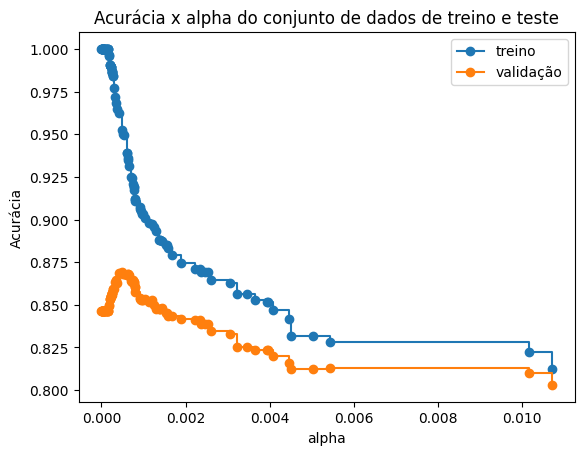

In [14]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
valid_scores = [clf.score(pc_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], valid_scores[:nx], marker='o', label="validação", drawstyle="steps-post")

ax.legend()
plt.show()

In [15]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    95.3
Acurácia da melhor árvore na base de validação: 86.9
Acurácia da melhor árvore na base de teste:     81.5


DecisionTreeClassifier(ccp_alpha=np.float64(0.00048435652089693824),
                       random_state=2360873)

### 🌳 Comparativo de Desempenho: Árvores de Decisão com PCA (10 componentes)

| Métrica                         | **Com Padronização** | **Sem Padronização** |
|--------------------------------|-----------------------:|------------------------:|
| Acurácia na base de treino     | 87.1%                 | 95.3%                  |
| Acurácia na base de validação  | 82.8%                 | 86.9%                  |
| **Acurácia na base de teste**  | **76.7%**             | **81.5%**              |

---

### 📌 Análise

- 🔹 **Árvores de decisão não exigem padronização**, pois tomam decisões com base em cortes nos valores das variáveis — não em distâncias.
- 🔸 A **padronização reduziu a performance** da árvore em todas as etapas, principalmente na base de teste.
- 🔹 O uso de **PCA com poucos componentes (n=10)** limita a informação disponível para o modelo, o que pode reduzir a acurácia.
- 🔸 **Sem padronização**, o modelo consegue capturar melhor as relações presentes nos dados originais.

---

### ✅ Conclusão

> Para modelos baseados em árvore, **não é necessário padronizar os dados**, e o uso de PCA deve ser avaliado com cautela, especialmente se estiver reduzindo demais as variáveis.

